# Test Difference Overlay Alignment
Verify that raw, cleaned, and difference meshes align properly in 3D space

In [9]:
import nibabel as nib
import numpy as np
import pyvista as pv
from skimage import measure
import matplotlib.pyplot as plt

print('Libraries loaded ✓')

c:\Users\nikhi\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated and will be removed in a future release
  "class": algorithms.Blowfish,


Libraries loaded ✓


In [10]:
# Load patient data
patient_id = 'BDMAP_00000006'

# Load raw predictions
raw_img = nib.load(f'{patient_id}/combined_labels.nii.gz')
raw_data = raw_img.get_fdata()

# Load cleaned predictions
cleaned_img = nib.load(f'{patient_id}/combined_labels_CLEANED.nii.gz')
cleaned_data = cleaned_img.get_fdata()

# Get spacing
spacing = raw_img.header.get_zooms()

print(f'Patient: {patient_id}')
print(f'Raw shape: {raw_data.shape}')
print(f'Cleaned shape: {cleaned_data.shape}')
print(f'Voxel spacing: {spacing}')
print(f'\nUnique labels in raw: {sorted(set(np.unique(raw_data)) - {0})}')
print(f'Unique labels in cleaned: {sorted(set(np.unique(cleaned_data)) - {0})}')

Patient: BDMAP_00000006
Raw shape: (267, 258, 651)
Cleaned shape: (267, 258, 651)
Voxel spacing: (0.78125, 0.78125, 2.5)

Unique labels in raw: [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0]
Unique labels in cleaned: [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0]


In [11]:
# Test with one vertebra - L5 (label 24) - this had significant cleaning
test_label = 24
vertebra_name = 'L5'

print(f'Testing with {vertebra_name} (label {test_label})')

# Extract masks
raw_mask = (raw_data == test_label).astype(np.uint8)
cleaned_mask = (cleaned_data == test_label).astype(np.uint8)

# Calculate differences
removed_mask = (raw_mask == 1) & (cleaned_mask == 0)  # In raw but not cleaned (False Positives)
added_mask = (cleaned_mask == 1) & (raw_mask == 0)    # In cleaned but not raw (False Negatives)
kept_mask = (raw_mask == 1) & (cleaned_mask == 1)     # In both (True Positives)

print(f'\nRaw voxels: {raw_mask.sum():,}')
print(f'Cleaned voxels: {cleaned_mask.sum():,}')
print(f'Removed (FP): {removed_mask.sum():,} ({100*removed_mask.sum()/raw_mask.sum():.1f}%)')
print(f'Added (FN): {added_mask.sum():,}')
print(f'Kept (TP): {kept_mask.sum():,}')

Testing with L5 (label 24)

Raw voxels: 4,412
Cleaned voxels: 3,360
Removed (FP): 1,162 (26.3%)
Added (FN): 110
Kept (TP): 3,250


In [12]:
def create_mesh_with_spacing(mask, spacing, step_size=1):
    """Create mesh with proper physical spacing applied"""
    if mask.sum() == 0:
        return None
    
    try:
        # Marching cubes WITH spacing - this converts voxel coords to physical coords
        verts, faces, normals, values = measure.marching_cubes(
            mask,
            level=0.5,
            spacing=spacing,  # CRITICAL: Apply physical spacing
            step_size=step_size
        )
        
        # Create PyVista mesh
        faces_vtk = np.hstack([np.full((faces.shape[0], 1), 3), faces]).astype(np.int64)
        mesh = pv.PolyData(verts, faces_vtk)
        
        return mesh
    except Exception as e:
        print(f'Error: {e}')
        return None

print('Creating meshes with physical spacing...')

# Create all three meshes
mesh_kept = create_mesh_with_spacing(kept_mask, spacing)      # True Positives
mesh_removed = create_mesh_with_spacing(removed_mask, spacing)  # False Positives (removed)
mesh_added = create_mesh_with_spacing(added_mask, spacing)      # False Negatives (added)

print(f'\nMeshes created:')
if mesh_kept:
    print(f'  Kept (TP): {mesh_kept.n_points:,} vertices')
    print(f'  Kept bounds: {mesh_kept.bounds}')
if mesh_removed:
    print(f'  Removed (FP): {mesh_removed.n_points:,} vertices')
    print(f'  Removed bounds: {mesh_removed.bounds}')
if mesh_added:
    print(f'  Added (FN): {mesh_added.n_points:,} vertices')
    print(f'  Added bounds: {mesh_added.bounds}')

Creating meshes with physical spacing...

Meshes created:
  Kept (TP): 2,943 vertices
  Kept bounds: BoundsTuple(x_min =   84.765625,
            x_max =  124.609375,
            y_min =  108.984375,
            y_max =  130.859375,
            z_min = 1318.75,
            z_max = 1346.25)
  Removed (FP): 4,268 vertices
  Removed bounds: BoundsTuple(x_min =   54.296875,
            x_max =  126.171875,
            y_min =   77.734375,
            y_max =  131.640625,
            z_min =  253.75,
            z_max = 1361.25)
  Added (FN): 476 vertices
  Added bounds: BoundsTuple(x_min =   86.328125,
            x_max =  123.046875,
            y_min =  116.015625,
            y_max =  128.515625,
            z_min = 1321.25,
            z_max = 1346.25)


In [14]:
# Check if meshes are in the same coordinate space
if mesh_kept and mesh_removed:
    kept_center = np.array(mesh_kept.center)
    removed_center = np.array(mesh_removed.center)
    
    print(f'Kept mesh center: {kept_center}')
    print(f'Removed mesh center: {removed_center}')
    print(f'Distance between centers: {np.linalg.norm(kept_center - removed_center):.2f} mm')
    
    # Check if bounding boxes overlap
    kept_bounds = np.array(mesh_kept.bounds).reshape(3, 2)
    removed_bounds = np.array(mesh_removed.bounds).reshape(3, 2)
    
    overlap = True
    for i in range(3):
        if kept_bounds[i, 1] < removed_bounds[i, 0] or removed_bounds[i, 1] < kept_bounds[i, 0]:
            overlap = False
            break
    
    print(f'\nBounding boxes overlap: {overlap}')
    if overlap:
        print('✓ Meshes are in the same coordinate space!')
    else:
        print('❌ Meshes are NOT overlapping - coordinate system issue!')

Kept mesh center: [ 104.6875    119.921875 1332.5     ]
Removed mesh center: [ 90.234375 104.6875   807.5     ]
Distance between centers: 525.42 mm

Bounding boxes overlap: True
✓ Meshes are in the same coordinate space!


Creating 3D visualization...


c:\Users\nikhi\anaconda3\Lib\site-packages\pyvista\jupyter\notebook.py:56: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


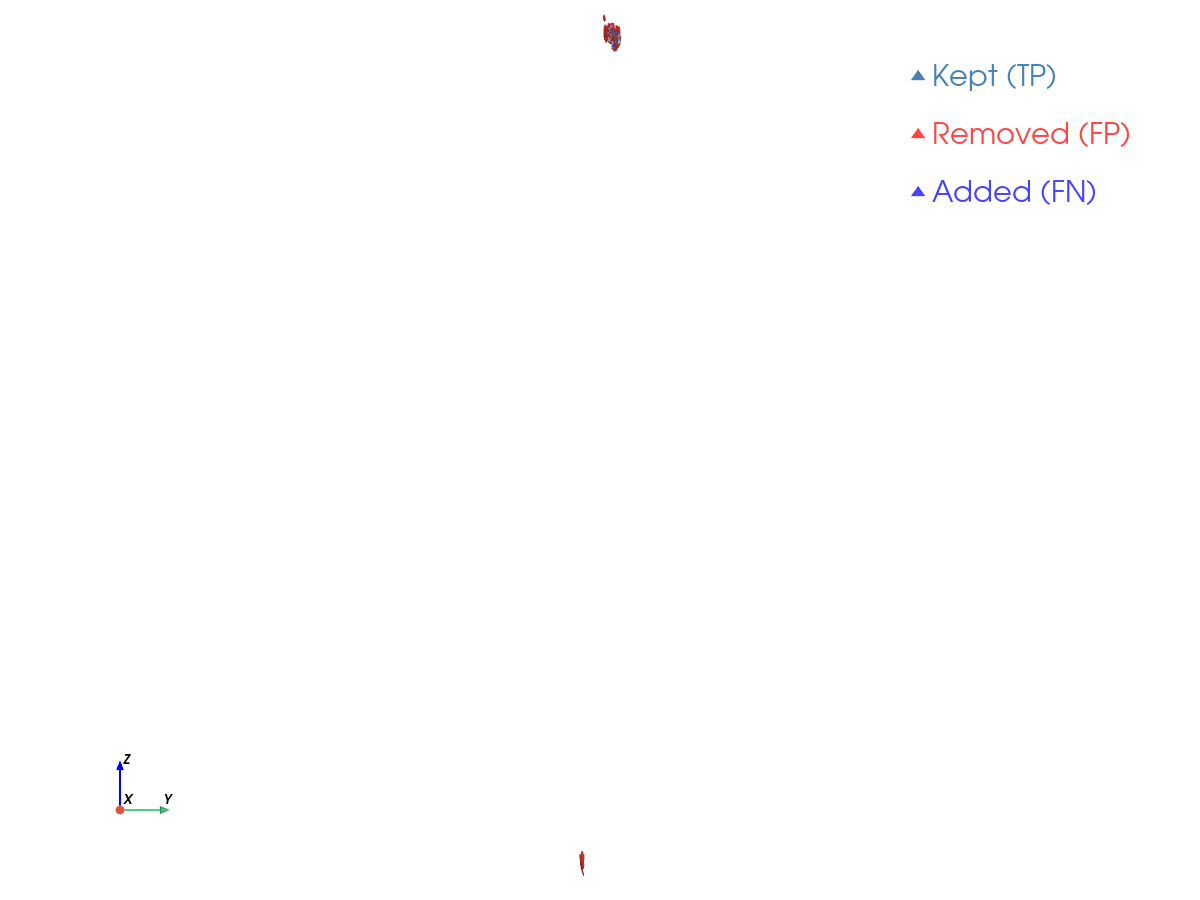


✓ Visualization complete!

Legend:
  Translucent steel blue = Kept vertebra (True Positive)
  Solid red = Removed noise (False Positive)
  Solid blue = Added parts (False Negative)

If they overlay properly, you should see red parts ON/NEAR the translucent vertebra
If they are side-by-side, there is a coordinate system issue!


In [15]:
# Visualize the overlay
print('Creating 3D visualization...')

plotter = pv.Plotter(window_size=[1200, 900])

# Add kept vertebra (True Positive) - TRANSLUCENT green/original color
if mesh_kept:
    plotter.add_mesh(
        mesh_kept,
        color='#4682B4',  # Steel blue (L5 color)
        opacity=0.3,      # 30% opacity - translucent
        label='Kept (TP)',
        show_edges=False
    )

# Add removed parts (False Positive) - SOLID red
if mesh_removed:
    plotter.add_mesh(
        mesh_removed,
        color='#FF4444',  # Red
        opacity=1.0,      # 100% opacity - solid
        label='Removed (FP)',
        show_edges=False
    )

# Add added parts (False Negative) - SOLID blue
if mesh_added:
    plotter.add_mesh(
        mesh_added,
        color='#4444FF',  # Blue
        opacity=1.0,      # 100% opacity - solid
        label='Added (FN)',
        show_edges=False
    )

# Configure view
plotter.add_legend()
plotter.add_axes()
plotter.camera_position = 'yz'  # Side view
plotter.background_color = 'white'

plotter.show()

print('\n✓ Visualization complete!')
print('\nLegend:')
print('  Translucent steel blue = Kept vertebra (True Positive)')
print('  Solid red = Removed noise (False Positive)')
print('  Solid blue = Added parts (False Negative)')
print('\nIf they overlay properly, you should see red parts ON/NEAR the translucent vertebra')
print('If they are side-by-side, there is a coordinate system issue!')

In [ ]:
# Test with another vertebra that had more cleaning - T12 (label 19)
test_label = 19
vertebra_name = 'T12'

print(f'\n' + '='*70)
print(f'Testing with {vertebra_name} (label {test_label}) - had 25.4% removed')
print('='*70)

# Extract masks
raw_mask = (raw_data == test_label).astype(np.uint8)
cleaned_mask = (cleaned_data == test_label).astype(np.uint8)
removed_mask = (raw_mask == 1) & (cleaned_mask == 0)
added_mask = (cleaned_mask == 1) & (raw_mask == 0)
kept_mask = (raw_mask == 1) & (cleaned_mask == 1)

print(f'Removed: {removed_mask.sum():,} voxels')
print(f'Added: {added_mask.sum():,} voxels')

# Create meshes
mesh_kept = create_mesh_with_spacing(kept_mask, spacing)
mesh_removed = create_mesh_with_spacing(removed_mask, spacing)
mesh_added = create_mesh_with_spacing(added_mask, spacing)

# Visualize
plotter = pv.Plotter(window_size=[1200, 900])

if mesh_kept:
    plotter.add_mesh(mesh_kept, color='#F0E68C', opacity=0.3, label='Kept (TP)')
if mesh_removed:
    plotter.add_mesh(mesh_removed, color='#FF4444', opacity=1.0, label='Removed (FP)')
if mesh_added:
    plotter.add_mesh(mesh_added, color='#4444FF', opacity=1.0, label='Added (FN)')

plotter.add_legend()
plotter.add_axes()
plotter.camera_position = 'yz'
plotter.background_color = 'white'
plotter.show()

print('\n✓ T12 visualization complete!')

Creating FULL SPINE difference visualization...
This may take a minute...
Processing 24 vertebrae...

Total removed mesh vertices: 16,639
Total added mesh vertices: 2,858


c:\Users\nikhi\anaconda3\Lib\site-packages\pyvista\jupyter\notebook.py:56: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


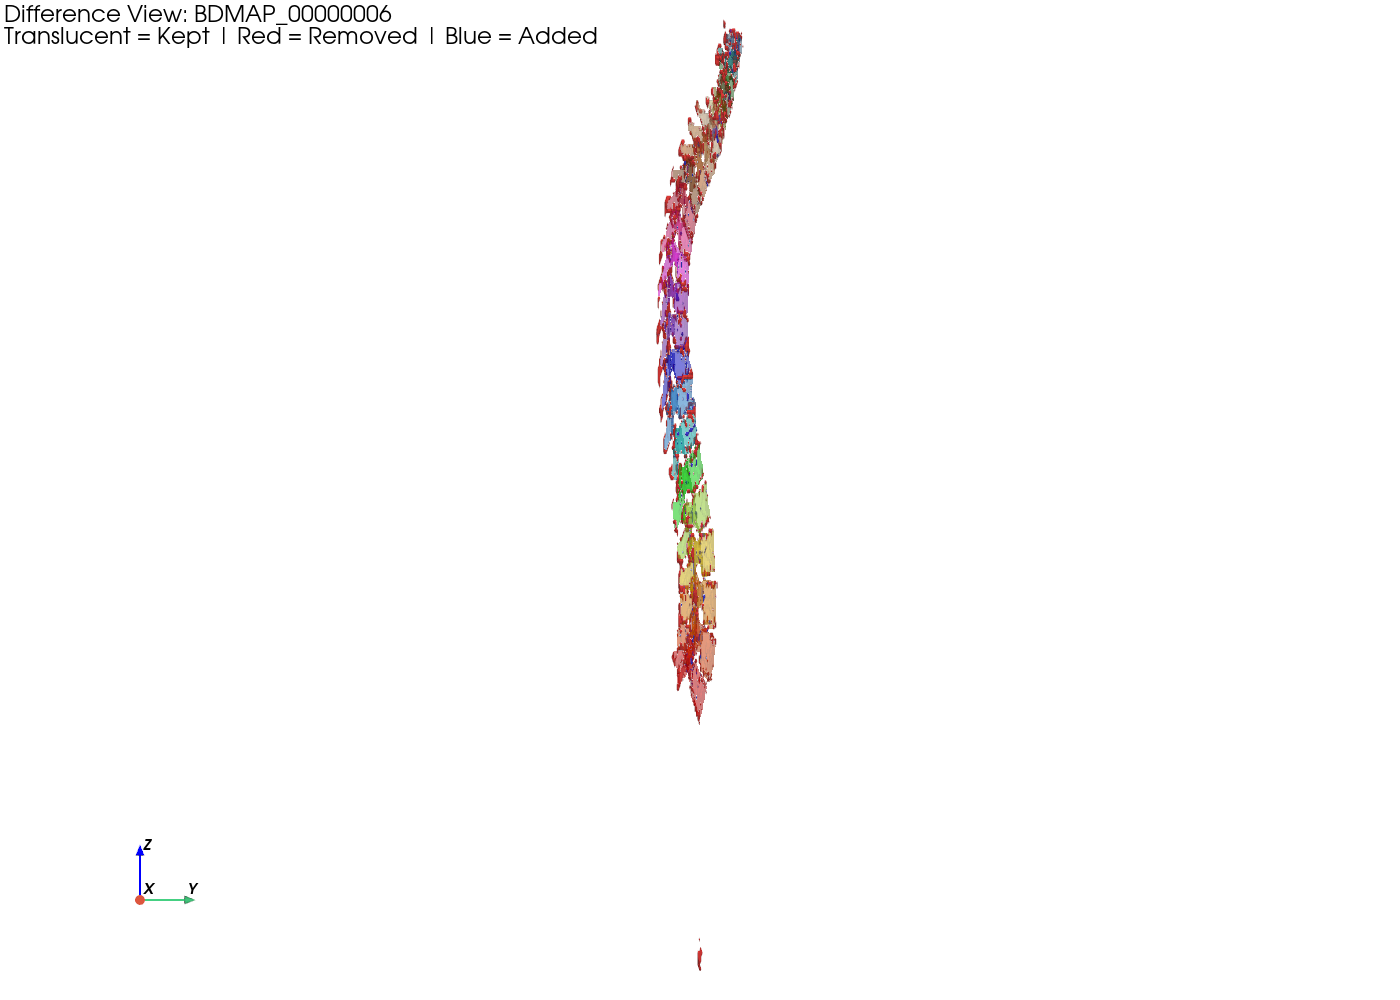


✓ Full spine difference visualization complete!

🔍 CHECK: Are the red removed parts overlaying the translucent vertebrae?
   Or are they appearing side-by-side as separate structures?


In [16]:
# Visualize ALL vertebrae with difference overlay
print('Creating FULL SPINE difference visualization...')
print('This may take a minute...')

plotter = pv.Plotter(window_size=[1400, 1000])

# Vertebrae colors
VERTEBRAE_COLORS = {
    1: '#FF0000', 2: '#FF4500', 3: '#FF8C00', 4: '#FFD700', 5: '#ADFF2F', 6: '#00FF00', 7: '#00CED1',
    8: '#1E90FF', 9: '#0000FF', 10: '#8A2BE2', 11: '#9400D3', 12: '#FF00FF', 13: '#FF1493', 14: '#DC143C',
    15: '#8B4513', 16: '#D2691E', 17: '#CD853F', 18: '#DEB887', 19: '#F0E68C',
    20: '#808000', 21: '#556B2F', 22: '#228B22', 23: '#008080', 24: '#4682B4'
}

labels_to_process = sorted(set(np.unique(cleaned_data)) - {0})
print(f'Processing {len(labels_to_process)} vertebrae...')

total_removed_vertices = 0
total_added_vertices = 0

for label_num in labels_to_process:
    # Extract masks
    raw_mask = (raw_data == label_num).astype(np.uint8)
    cleaned_mask = (cleaned_data == label_num).astype(np.uint8)
    removed_mask = (raw_mask == 1) & (cleaned_mask == 0)
    added_mask = (cleaned_mask == 1) & (raw_mask == 0)
    kept_mask = (raw_mask == 1) & (cleaned_mask == 1)
    
    # Create meshes
    mesh_kept = create_mesh_with_spacing(kept_mask, spacing, step_size=2)  # Faster
    
    if mesh_kept:
        color = VERTEBRAE_COLORS.get(label_num, '#CCCCCC')
        plotter.add_mesh(mesh_kept, color=color, opacity=0.3, show_edges=False)
    
    # Add removed parts (red)
    if removed_mask.sum() > 100:  # Only if significant
        mesh_removed = create_mesh_with_spacing(removed_mask, spacing, step_size=2)
        if mesh_removed:
            plotter.add_mesh(mesh_removed, color='#FF4444', opacity=1.0, show_edges=False)
            total_removed_vertices += mesh_removed.n_points
    
    # Add added parts (blue)
    if added_mask.sum() > 100:
        mesh_added = create_mesh_with_spacing(added_mask, spacing, step_size=2)
        if mesh_added:
            plotter.add_mesh(mesh_added, color='#4444FF', opacity=1.0, show_edges=False)
            total_added_vertices += mesh_added.n_points

print(f'\nTotal removed mesh vertices: {total_removed_vertices:,}')
print(f'Total added mesh vertices: {total_added_vertices:,}')

# Add text annotation
plotter.add_text(
    f'Difference View: {patient_id}\nTranslucent = Kept | Red = Removed | Blue = Added',
    position='upper_left',
    font_size=12,
    color='black'
)

plotter.add_axes()
plotter.camera_position = 'yz'
plotter.background_color = 'white'
plotter.show()

print('\n✓ Full spine difference visualization complete!')
print('\n🔍 CHECK: Are the red removed parts overlaying the translucent vertebrae?')
print('   Or are they appearing side-by-side as separate structures?')